In [49]:
import pandas as pd
import numpy as np

# Load the hitters data with contracts
hitters_df = pd.read_csv('data/Hitters_Training_Data.csv')

print(f"Total hitters: {len(hitters_df)}")
print(f"Hitters with AnnualValue: {hitters_df['AnnualValue'].notna().sum()}")
print(f"Hitters without AnnualValue: {hitters_df['AnnualValue'].isna().sum()}")
print(f"\nMatch rate: {hitters_df['AnnualValue'].notna().sum() / len(hitters_df) * 100:.1f}%")
print(hitters_df["AnnualValue"].notna())






Total hitters: 1867
Hitters with AnnualValue: 1867
Hitters without AnnualValue: 0

Match rate: 100.0%
0       True
1       True
2       True
3       True
4       True
        ... 
1862    True
1863    True
1864    True
1865    True
1866    True
Name: AnnualValue, Length: 1867, dtype: bool


In [50]:
# View all column names
print("All columns:")
print(hitters_df.columns.tolist())

# View a row that has AnnualValue to see available data
print("\nSample row with AnnualValue:")
sample = hitters_df[hitters_df['AnnualValue'].notna()].iloc[0]
print(sample)


All columns:
['Name', 'Age', '#days', 'Lev', 'Tm', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'mlbID', 'Name_bat', 'swings_competitive', 'percent_swings_competitive', 'contact', 'avg_bat_speed', 'hard_swing_rate', 'squared_up_per_bat_contact', 'squared_up_per_swing', 'blast_per_bat_contact', 'blast_per_swing', 'swing_length', 'swords', 'batter_run_value', 'whiffs', 'whiff_per_swing', 'batted_ball_events', 'batted_ball_event_per_swing', 'Name_ev', 'attempts', 'avg_hit_angle', 'anglesweetspotpercent', 'max_hit_speed', 'avg_hit_speed', 'ev50', 'fbld', 'gb', 'max_distance', 'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels', 'brl_percent', 'brl_pa', 'Name_x', 'year', 'pa', 'bip', 'ba', 'est_ba', 'est_ba_minus_ba_diff', 'slg', 'est_slg', 'est_slg_minus_slg_diff', 'woba', 'est_woba', 'est_woba_minus_woba_diff', 'Name_sprint', 'team_id', 'team', 'position', 'age', 'competitive_run

In [51]:
# Filter to only hitters with salary data
hitters_with_salary = hitters_df[hitters_df['AnnualValue'].notna()].copy()

print(f"Hitters with salary data: {len(hitters_with_salary)}")
print(f"\nSalary distribution:")
print(hitters_with_salary['AnnualValue'].describe())

print(f"\nBy season:")
print(hitters_with_salary.groupby('Season').size())


Hitters with salary data: 1867

Salary distribution:
count    1.867000e+03
mean     4.215128e+06
std      7.255832e+06
min      8.000000e+03
25%      7.400000e+05
50%      7.670000e+05
75%      4.000000e+06
max      7.000000e+07
Name: AnnualValue, dtype: float64

By season:
Season
2023    615
2024    613
2025    639
dtype: int64


In [52]:
# View ALL players without salary data
missing_salary = hitters_df[hitters_df['AnnualValue'].isna()][['Name', 'Tm', 'Season', 'PA', 'WAR']]
print(f"Players without salary data ({len(missing_salary)} total):\n")

# Show all players sorted by WAR
pd.set_option('display.max_rows', None)
display(missing_salary.sort_values('WAR', ascending=False))
pd.reset_option('display.max_rows')


Players without salary data (0 total):



,Name,Tm,Season,PA,WAR


In [29]:

# Create the training dataset (only hitters with salary data)
# You can use hitters_with_salary for training

# Optional: Save filtered data
hitters_with_salary.to_csv('data/Hitters_Training_Data.csv', index=False)
print(f"Saved {len(hitters_with_salary)} hitters with salary data to 'data/Hitters_Training_Data.csv'")

# Preview the data
print(f"\nSample of training data:")
hitters_with_salary[['Name', 'Season', 'PA', 'WAR', 'OPS', 'AnnualValue']].head(10)

Saved 1867 hitters with salary data to 'data/Hitters_Training_Data.csv'

Sample of training data:


,Name,Season,PA,WAR,OPS,AnnualValue
0,CJ Abrams,2023,614,3.45,0.712,724200.0
1,Jos\xc3\xa9 Abreu,2023,642,-0.09,0.700,19500000.0
2,Wilyer Abreu,2023,85,0.67,0.862,720000.0
3,Ronald Acu\xc3\xb1a Jr.,2023,752,8.40,1.001,17000000.0
4,Willy Adames,2023,646,2.91,0.724,8700000.0
5,Jordyn Adams,2023,40,-0.71,0.253,720000.0
6,Riley Adams,2023,158,1.07,0.807,728800.0
7,Jo Adell,2023,62,0.34,0.706,720000.0
8,Jes\xc3\xbas Aguilar,2023,115,-0.60,0.665,3000000.0
9,Nick Ahmed,2023,210,-0.26,0.560,10625000.0


# Pitcher Training Data Preparation


In [53]:
import unicodedata
import re
import codecs

def fix_escaped_unicode(name):
    """Decode escaped UTF-8 bytes back to proper unicode"""
    if pd.isna(name):
        return ''
    name = str(name)
    if '\\x' in name:
        try:
            name = codecs.decode(name, 'unicode_escape')
            name = name.encode('latin-1').decode('utf-8')
        except:
            pass
    return name

def extract_spotrac_name(name):
    """Fix Spotrac format: 'LastName Suffix FirstName LastName' -> 'FirstName LastName'"""
    if pd.isna(name):
        return ''
    name = str(name).strip()
    
    # Remove leading numbers
    name = re.sub(r'^\d+\s+', '', name)
    
    # Handle suffix patterns (Jr., II, etc.)
    suffix_patterns = [r'\s+Jr\.?\s+', r'\s+Sr\.?\s+', r'\s+II\s+', r'\s+III\s+', r'\s+IV\s+']
    for pattern in suffix_patterns:
        match = re.search(pattern, name, re.IGNORECASE)
        if match:
            after = name[match.end():].strip()
            if after:
                return after
    
    # Handle repeated name pattern (no suffix)
    words = name.split()
    if len(words) >= 3:
        for i in range(1, len(words) // 2 + 1):
            start_part = ' '.join(words[:i]).lower()
            end_part = ' '.join(words[-i:]).lower()
            if start_part == end_part:
                return ' '.join(words[i:])
    return name

def normalize_name(name, is_contract=False):
    """Normalize name for matching between datasets"""
    if pd.isna(name):
        return ''
    
    name = fix_escaped_unicode(name)
    if is_contract:
        name = extract_spotrac_name(name)
    
    name = unicodedata.normalize('NFD', name)
    name = ''.join(c for c in name if unicodedata.category(c) != 'Mn')
    name = name.lower()
    
    # Remove middle initials and periods
    name = re.sub(r'\b\w\.\s*', '', name)
    name = name.replace('.', '')
    name = re.sub(r'[^\w\s]', '', name)
    
    # Remove suffixes at end
    for suffix in [' jr', ' sr', ' iii', ' ii', ' iv']:
        if name.endswith(suffix):
            name = name[:-len(suffix)]
    
    return ' '.join(name.split()).strip()

# Load pitcher data
pitchers_df = pd.read_csv('data/Pitchers_2015-2025_byYear_retry.csv')
pitcher_contracts = pd.read_csv('data/Pitcher_Contracts_2015-2025.csv')

print(f"Pitchers data: {len(pitchers_df)} records")
print(f"Pitcher contracts: {len(pitcher_contracts)} records")
print(f"\nPitcher years: {sorted(pitchers_df['Season'].unique())}")


Pitchers data: 8968 records
Pitcher contracts: 9635 records

Pitcher years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


In [31]:
# Normalize names for matching
pitchers_df['Name_match'] = pitchers_df['Name'].apply(lambda x: normalize_name(x, is_contract=False))
pitcher_contracts['Name_match'] = pitcher_contracts['Name'].apply(lambda x: normalize_name(x, is_contract=True))

# Ensure Season is int
pitcher_contracts['Season'] = pitcher_contracts['Season'].astype(int)
pitchers_df['Season'] = pitchers_df['Season'].astype(int)

# Merge on normalized name and season
pitchers_merged = pitchers_df.merge(
    pitcher_contracts[['Name_match', 'Season', 'Salary', 'AnnualValue', 'Position']],
    on=['Name_match', 'Season'],
    how='left',
    suffixes=('', '_contract')
)

# Drop the match column
pitchers_merged = pitchers_merged.drop(columns=['Name_match'])

# Stats
matched = pitchers_merged['AnnualValue'].notna().sum()
total = len(pitchers_merged)
print(f"Total pitchers: {total}")
print(f"Pitchers with AnnualValue: {matched}")
print(f"Pitchers without AnnualValue: {total - matched}")
print(f"\nMatch rate: {matched/total*100:.1f}%")

print(f"\nBy season:")
print(pitchers_merged.groupby('Season').apply(lambda x: f"{x['AnnualValue'].notna().sum()}/{len(x)}"))


Total pitchers: 9313
Pitchers with AnnualValue: 8666
Pitchers without AnnualValue: 647

Match rate: 93.1%

By season:
Season
2015    700/743
2016    730/763
2017    752/785
2018    764/822
2019    784/849
2020    713/749
2021    875/950
2022    842/923
2023    828/901
2024    840/903
2025    838/925
dtype: object


/var/folders/r3/xfw8t29x0r1b_8dl0_phj1ch0000gn/T/ipykernel_39942/718364100.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(pitchers_merged.groupby('Season').apply(lambda x: f"{x['AnnualValue'].notna().sum()}/{len(x)}"))


In [54]:
# Filter to only pitchers with salary data
pitchers_with_salary = pitchers_merged[pitchers_merged['AnnualValue'].notna()].copy()

print(f"Pitchers with salary data: {len(pitchers_with_salary)}")
print(f"\nSalary distribution:")
print(pitchers_with_salary['AnnualValue'].describe())

# View players without salary (top by WAR)
missing_salary = pitchers_merged[pitchers_merged['AnnualValue'].isna()][['Name', 'Tm', 'Season', 'IP', 'WAR']]
print(f"\nTop 20 pitchers without salary data (by WAR):")
display(missing_salary.sort_values('WAR', ascending=False).head(20))


Pitchers with salary data: 8666

Salary distribution:
count    8.666000e+03
mean     2.473676e+06
std      4.641804e+06
min      2.773000e+03
25%      5.550000e+05
50%      7.200000e+05
75%      1.750000e+06
max      4.333333e+07
Name: AnnualValue, dtype: float64

Top 20 pitchers without salary data (by WAR):


,Name,Tm,Season,IP,WAR
6265,Shohei Ohtani,Los Angeles,2022,166.0,6.22
3769,Hyun Jin Ryu,Los Angeles,2019,182.2,5.14
2517,Mike Fiers,"Detroit,Oakland",2018,172.0,4.38
5329,Shohei Ohtani,Los Angeles,2021,130.1,4.07
7168,Shohei Ohtani,Los Angeles,2023,132.0,3.85
3353,Mike Fiers,Oakland,2019,184.2,3.36
4546,Hyun Jin Ryu,Toronto,2020,67.0,2.90
2934,Hyun Jin Ryu,Los Angeles,2018,82.1,2.17
9295,Simeon Woods Richardson,Minnesota,2025,111.1,2.16
2666,Jakob Junis,Kansas City,2018,177.0,2.09


In [33]:
# Save pitcher training data
pitchers_with_salary.to_csv('data/Pitchers_Training_Data.csv', index=False)
print(f"Saved {len(pitchers_with_salary)} pitchers with salary data to 'data/Pitchers_Training_Data.csv'")

# Also save the full merged data (with missing salaries)
pitchers_merged.to_csv('data/Pitchers_with_Contracts.csv', index=False)
print(f"Saved {len(pitchers_merged)} total pitcher records to 'data/Pitchers_with_Contracts.csv'")

# Preview the training data
print(f"\nSample of pitcher training data:")
pitchers_with_salary[['Name', 'Season', 'IP', 'ERA', 'SO', 'WAR', 'AnnualValue']].head(10)


Saved 8666 pitchers with salary data to 'data/Pitchers_Training_Data.csv'
Saved 9313 total pitcher records to 'data/Pitchers_with_Contracts.csv'

Sample of pitcher training data:


,Name,Season,IP,ERA,SO,WAR,AnnualValue
1,Fernando Abad,2015,47.2,4.15,45,0.18,1087500.0
2,A.J. Achter,2015,13.1,6.75,14,-0.18,507500.0
3,Austin Adams,2015,33.1,3.78,23,0.30,507700.0
4,Nathan Adcock,2015,18.0,6.00,13,-0.22,332786.0
5,Jeremy Affeldt,2015,35.1,5.86,21,-0.80,5000000.0
6,Andrew Albers,2015,2.2,3.38,1,0.04,507500.0
7,Matt Albers,2015,37.1,1.21,28,1.42,1500000.0
8,Al Alburquerque,2015,62.0,4.21,58,0.35,1725000.0
9,Scott Alexander,2015,6.0,4.50,3,0.02,507500.0
10,Cody Allen,2015,70.0,2.96,99,1.25,547100.0


In [79]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load hitter training data
hitters = pd.read_csv('data/Hitters_Training_Data.csv')

# Define features for hitters
hitter_features = ['Age', 'G', 'PA', 'WAR']

# Check which features are available
available_features = [f for f in hitter_features if f in hitters.columns]
missing_features = [f for f in hitter_features if f not in hitters.columns]

print(f"Available features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Prepare data - drop rows with missing values in features
df = hitters[['Name', 'Season', 'AnnualValue'] + available_features].copy()
df = df.dropna(subset=available_features + ['AnnualValue'])

# Log transform target
df['log_salary'] = np.log(df['AnnualValue'])

print(f"\nData shape after cleaning: {df.shape}")
print(f"\nSalary distribution:")
print(df['AnnualValue'].describe())


Available features (4): ['Age', 'G', 'PA', 'WAR']

Data shape after cleaning: (1867, 8)

Salary distribution:
count    1.867000e+03
mean     4.215128e+06
std      7.255832e+06
min      8.000000e+03
25%      7.400000e+05
50%      7.670000e+05
75%      4.000000e+06
max      7.000000e+07
Name: AnnualValue, dtype: float64


In [80]:
# Temporal split: Train on 2023-2024, Test on 2025
train_df = df[df['Season'].isin([2023, 2024])]
test_df = df[df['Season'] == 2025]

print(f"Training set: {len(train_df)} samples (2023-2024)")
print(f"Test set: {len(test_df)} samples (2025)")

# Prepare X and y
X_train = train_df[available_features]
y_train = train_df['log_salary']
X_test = test_df[available_features]
y_test = test_df['log_salary']

# Also keep original salaries for evaluation
y_train_orig = train_df['AnnualValue']
y_test_orig = test_df['AnnualValue']

# Scale features (important for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature matrix shape: {X_train_scaled.shape}")


Training set: 1228 samples (2023-2024)
Test set: 639 samples (2025)

Feature matrix shape: (1228, 4)


In [102]:
# Define models to compare
models = {
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

def evaluate_model(y_true_log, y_pred_log, y_true_orig):
    """Evaluate model on both log and original scale"""
    # Convert predictions back to original scale
    y_pred_orig = np.exp(y_pred_log)
    
    # Metrics on log scale
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    
    # Metrics on original scale (dollars)
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100
    
    return {
        'RMSE (log)': rmse_log,
        'RMSE ($)': rmse,
        'MAE ($)': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

# Train and evaluate all models
results = []
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled features for linear models, unscaled for tree-based
    if 'Forest' in name or 'Boosting' in name:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    metrics = evaluate_model(y_test, y_pred, y_test_orig)
    metrics['Model'] = name
    results.append(metrics)
    trained_models[name] = model

# Display results
results_df = pd.DataFrame(results)[['Model', 'R²', 'RMSE ($)', 'MAE ($)', 'MAPE (%)']]
results_df['RMSE ($)'] = results_df['RMSE ($)'].apply(lambda x: f"${x:,.0f}")
results_df['MAE ($)'] = results_df['MAE ($)'].apply(lambda x: f"${x:,.0f}")
results_df['MAPE (%)'] = results_df['MAPE (%)'].apply(lambda x: f"{x:.1f}%")
results_df['R²'] = results_df['R²'].apply(lambda x: f"{x:.3f}")

print("\n" + "="*70)
print("MODEL COMPARISON - Hitter Salary Prediction (Test on 2025)")
print("="*70)
display(results_df)

Training Gradient Boosting...

MODEL COMPARISON - Hitter Salary Prediction (Test on 2025)


,Model,R²,RMSE ($),MAE ($),MAPE (%)
0,Gradient Boosting,0.532,"$5,111,648","$2,322,204",101.3%


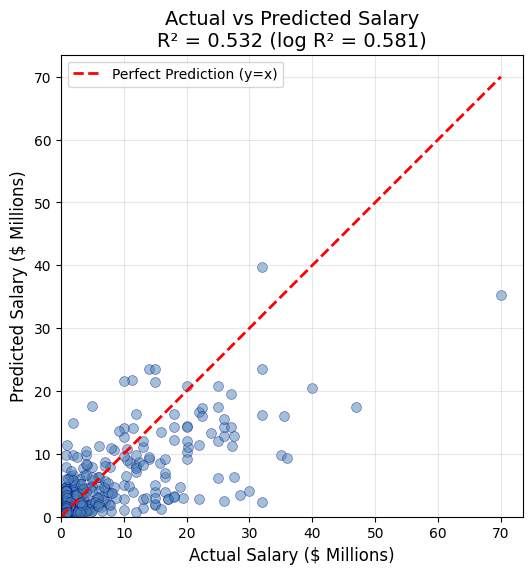

In [105]:
# Create comparison dataframe - convert log predictions back to dollars!
comparison = test_df[['Name', 'Season', 'AnnualValue']].copy()
comparison['Predicted'] = np.exp(y_pred)  # Convert from log scale to dollars
comparison['Error'] = comparison['Predicted'] - comparison['AnnualValue']

# Calculate R² 
r2 = r2_score(comparison['AnnualValue'], comparison['Predicted'])
r2_log = r2_score(y_test, y_pred)

# Create plots
fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

# Plot 1: Actual vs Predicted

ax1.scatter(comparison['AnnualValue'] / 1e6, comparison['Predicted'] / 1e6, 
            alpha=0.5, s=50, c='steelblue', edgecolors='navy', linewidth=0.5)
max_val = max(comparison['AnnualValue'].max(), comparison['Predicted'].max()) / 1e6
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
ax1.set_xlabel('Actual Salary ($ Millions)', fontsize=12)
ax1.set_ylabel('Predicted Salary ($ Millions)', fontsize=12)
ax1.set_title(f'Actual vs Predicted Salary\nR² = {r2:.3f} (log R² = {r2_log:.3f})', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max_val * 1.05)
ax1.set_ylim(0, max_val * 1.05)
ax1.set_aspect('equal')



In [106]:
# Show sample predictions vs actual
comparison['WAR'] = test_df['WAR'].values

# Format for display
comparison_display = comparison.copy()
comparison_display['Actual'] = comparison_display['AnnualValue'].apply(lambda x: f"${x/1e6:.1f}M")
comparison_display['Pred'] = comparison_display['Predicted'].apply(lambda x: f"${x/1e6:.1f}M")
comparison_display['Diff'] = comparison_display['Error'].apply(lambda x: f"${x/1e6:+.1f}M")

print("Top 10 Highest Paid Hitters - Predicted vs Actual (2025):")
top_paid = comparison.nlargest(10, 'AnnualValue')
display(comparison_display.loc[top_paid.index][['Name', 'WAR', 'Actual', 'Pred', 'Diff']])

print("\nMost Overpaid (Model predicts lower salary):")
display(comparison_display.nlargest(5, 'Error')[['Name', 'WAR', 'Actual', 'Pred', 'Diff']])

print("\nMost Underpaid / Best Value (Model predicts higher salary):")
display(comparison_display.nsmallest(5, 'Error')[['Name', 'WAR', 'Actual', 'Pred', 'Diff']])


Top 10 Highest Paid Hitters - Predicted vs Actual (2025):


,Name,WAR,Actual,Pred,Diff
1640,Shohei Ohtani,6.62,$70.0M,$35.3M,$-34.7M
1755,Juan Soto,6.24,$46.9M,$17.4M,$-29.5M
1498,Aaron Judge,9.70,$40.0M,$20.5M,$-19.5M
1346,Carlos Correa,1.46,$36.0M,$9.4M,$-26.6M
1803,Mike Trout,1.51,$35.5M,$16.0M,$-19.4M
1294,Alex Bregman,3.46,$35.0M,$9.8M,$-25.2M
1253,Nolan Arenado,1.29,$32.0M,$16.2M,$-15.8M
1539,Francisco Lindor,5.87,$32.0M,$23.5M,$-8.5M
1732,Corey Seager,6.15,$32.0M,$39.7M,$+7.7M
1759,Giancarlo Stanton,1.87,$32.0M,$2.3M,$-29.7M



Most Overpaid (Model predicts lower salary):


,Name,WAR,Actual,Pred,Diff
1774,Mike Tauchman,1.89,$1.9M,$14.9M,$+13.0M
1587,Andrew McCutchen,0.12,$5.0M,$17.7M,$+12.7M
1372,Yandy D\xc3\xadaz,3.39,$10.0M,$21.6M,$+11.6M
1255,Randy Arozarena,4.03,$11.3M,$21.7M,$+10.4M
1673,Cal Raleigh,7.37,$1.0M,$11.4M,$+10.4M



Most Underpaid / Best Value (Model predicts higher salary):


,Name,WAR,Actual,Pred,Diff
1640,Shohei Ohtani,6.62,$70.0M,$35.3M,$-34.7M
1759,Giancarlo Stanton,1.87,$32.0M,$2.3M,$-29.7M
1755,Juan Soto,6.24,$46.9M,$17.4M,$-29.5M
1346,Carlos Correa,1.46,$36.0M,$9.4M,$-26.6M
1242,Jose Altuve,0.49,$30.0M,$4.2M,$-25.8M


NameError: name 'y_test_p_orig' is not defined

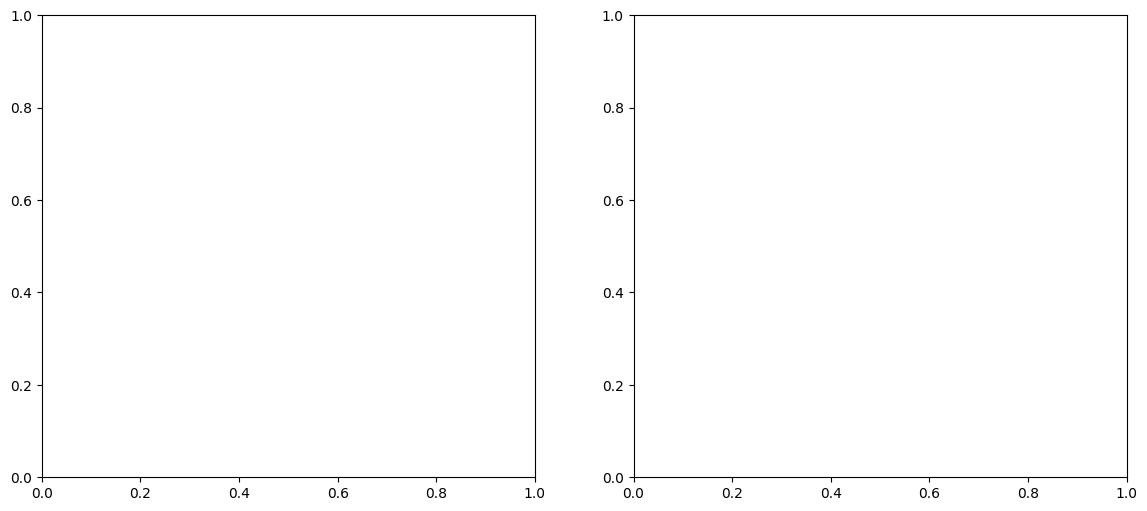

In [107]:
# Pitcher Salary Prediction


In [110]:
# Load pitcher training data
pitchers = pd.read_csv('data/Pitchers_Training_Data.csv')

# Define features for pitchers
pitcher_features = ['Age', 'G', 'IP', 'WAR']

# Check which features are available
available_p_features = [f for f in pitcher_features if f in pitchers.columns]
print(f"Available features ({len(available_p_features)}): {available_p_features}")

# Prepare data
df_p = pitchers[['Name', 'Season', 'AnnualValue'] + available_p_features].copy()
df_p = df_p.dropna(subset=available_p_features + ['AnnualValue'])
df_p['log_salary'] = np.log(df_p['AnnualValue'])

print(f"\nData shape after cleaning: {df_p.shape}")
print(f"\nPitcher salary distribution:")
print(df_p['AnnualValue'].describe())


Available features (4): ['Age', 'G', 'IP', 'WAR']

Data shape after cleaning: (7758, 8)

Pitcher salary distribution:
count    7.758000e+03
mean     2.508491e+06
std      4.726652e+06
min      2.773000e+03
25%      5.550000e+05
50%      7.200000e+05
75%      1.768750e+06
max      4.333333e+07
Name: AnnualValue, dtype: float64


In [112]:
# Temporal split for pitchers - train on 2015-2024, test on 2025
train_p = df_p[df_p['Season'] < 2025]
test_p = df_p[df_p['Season'] == 2025]

print(f"Training set: {len(train_p)} samples (2015-2024)")
print(f"Test set: {len(test_p)} samples (2025)")

# Prepare X and y
X_train_p = train_p[available_p_features]
y_train_p = train_p['log_salary']
X_test_p = test_p[available_p_features]
y_test_p = test_p['log_salary']
y_test_p_orig = test_p['AnnualValue']

# Scale features
scaler_p = StandardScaler()
X_train_p_scaled = scaler_p.fit_transform(X_train_p)
X_test_p_scaled = scaler_p.transform(X_test_p)

# Train and evaluate multiple models
p_models = {
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

p_results = []
p_trained_models = {}

for name, model in p_models.items():
    if 'Forest' in name or 'Boosting' in name:
        model.fit(X_train_p, y_train_p)
        y_pred_p = model.predict(X_test_p)
    else:
        model.fit(X_train_p_scaled, y_train_p)
        y_pred_p = model.predict(X_test_p_scaled)
    
    metrics = evaluate_model(y_test_p, y_pred_p, y_test_p_orig)
    metrics['Model'] = name
    p_results.append(metrics)
    p_trained_models[name] = (model, y_pred_p)

# Display results
p_results_df = pd.DataFrame(p_results)[['Model', 'R²', 'RMSE ($)', 'MAE ($)', 'MAPE (%)']]
p_results_df['RMSE ($)'] = p_results_df['RMSE ($)'].apply(lambda x: f"${x:,.0f}")
p_results_df['MAE ($)'] = p_results_df['MAE ($)'].apply(lambda x: f"${x:,.0f}")
p_results_df['MAPE (%)'] = p_results_df['MAPE (%)'].apply(lambda x: f"{x:.1f}%")
p_results_df['R²'] = p_results_df['R²'].apply(lambda x: f"{x:.3f}")

print("="*70)
print("MODEL COMPARISON - Pitcher Salary Prediction (Test on 2025)")
print("="*70)
display(p_results_df)


Training set: 6987 samples (2015-2024)
Test set: 771 samples (2025)
MODEL COMPARISON - Pitcher Salary Prediction (Test on 2025)


,Model,R²,RMSE ($),MAE ($),MAPE (%)
0,Gradient Boosting,0.435,"$3,863,019","$1,703,949",111.8%


In [ ]:
# Show pitcher predictions vs actual
comp_p_display = comp_p.copy()
comp_p_display['Actual'] = comp_p_display['AnnualValue'].apply(lambda x: f"${x/1e6:.1f}M")
comp_p_display['Pred'] = comp_p_display['Predicted'].apply(lambda x: f"${x/1e6:.1f}M")
comp_p_display['Diff'] = comp_p_display['Error'].apply(lambda x: f"${x/1e6:+.1f}M")

print("Top 10 Highest Paid Pitchers - Predicted vs Actual (2025):")
top_paid_p = comp_p.nlargest(10, 'AnnualValue')
display(comp_p_display.loc[top_paid_p.index][['Name', 'WAR', 'Actual', 'Pred', 'Diff']])

print("\nMost Overpaid Pitchers (Model predicts lower salary):")
display(comp_p_display.nsmallest(5, 'Error')[['Name', 'WAR', 'Actual', 'Pred', 'Diff']])

print("\nMost Underpaid / Best Value Pitchers:")
display(comp_p_display.nlargest(5, 'Error')[['Name', 'WAR', 'Actual', 'Pred', 'Diff']])


Top 10 Highest Paid Pitchers - Predicted vs Actual (2025):


,Name,WAR,Actual,Pred,Diff
8628,Zack Wheeler,5.02,$42.0M,$19.0M,$-23.0M
8005,Jacob deGrom,2.93,$40.0M,$21.2M,$-18.8M
7938,Corbin Burnes,1.96,$30.0M,$9.8M,$-20.2M
8110,Tyler Glasnow,1.91,$30.0M,$5.0M,$-25.0M
8530,Blake Snell,1.27,$26.0M,$5.9M,$-20.1M
8122,Sonny Gray,1.44,$25.0M,$11.9M,$-13.1M
8283,Sean Manaea,-0.38,$25.0M,$2.8M,$-22.2M
8441,Robbie Ray,2.77,$25.0M,$12.7M,$-12.3M
8370,Aaron Nola,-0.27,$24.6M,$6.8M,$-17.8M
8092,Kevin Gausman,3.82,$23.0M,$17.8M,$-5.2M



Most Overpaid Pitchers (Model predicts lower salary):


,Name,WAR,Actual,Pred,Diff
8110,Tyler Glasnow,1.91,$30.0M,$5.0M,$-25.0M
8628,Zack Wheeler,5.02,$42.0M,$19.0M,$-23.0M
8283,Sean Manaea,-0.38,$25.0M,$2.8M,$-22.2M
7955,Luis Castillo,1.76,$22.8M,$1.1M,$-21.6M
7938,Corbin Burnes,1.96,$30.0M,$9.8M,$-20.2M



Most Underpaid / Best Value Pitchers:


,Name,WAR,Actual,Pred,Diff
8418,Nick Pivetta,5.28,$1.0M,$13.7M,$+12.7M
7958,Luis Castillo,1.76,$0.8M,$13.1M,$+12.3M
7976,Patrick Corbin,-0.44,$1.1M,$9.9M,$+8.8M
8430,Jose Quintana,1.31,$2.0M,$10.7M,$+8.7M
7912,Matthew Boyd,2.54,$7.5M,$14.6M,$+7.1M
